In [12]:
# load packages
import ixmp                    # package for ix modeling platform
import message_ix              # package for MESSAGEix model
from message_ix.utils import make_df
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use("ggplot")
import pandas as pd

from ixmp.reporting import configure
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots
from functools import partial


In [2]:
# The IAMC format does not have 'level', 'technology', or 'commodity'
# columns; only a catch-all 'Variable' column.
def format_variable(df, key='out'):
    """Callback function to fill the IAMC 'variable' column."""
    if key=='out':
        df['variable'] = df['l'] + ' energy|' + df['t'] + '|' + df['c'] + '(' + df['scenario'] + ')'
        df = df.drop(['c', 'l', 't'], axis=1)
    if key=='emission_factor':
        df['variable'] = df['e'] +'(' + df['scenario'] + ')'
        df = df.drop(['e'], axis=1)
    return df

# Add node(s) that convert data to pyam.IamDataFrame objects
def quick_convert(rep, key='out'):
    out = rep.full_key(key)
    part = partial(format_variable,key=key)
    if key=='out':
        new_key = rep.convert_pyam(
            # SRC Westeros_report
            # Quantity or quantities to convert
            quantities=out.drop('h', 'hd', 'm', 'nd', 'yv'),
            # Dimensions to use for the 'Region' and 'Year' IAMC columns
            rename=dict(nl="region", ya="year"),
            # Use this function to collapse the 'l', 't', and 'c' dimensions
            # into the 'Variable' IAMC column
            collapse=part
        )
    if key=='emission_factor':
        new_key = rep.convert_pyam(
            # SRC Westeros_report
            # Quantity or quantities to convert
            quantities=out.drop('h', 'hd', 'm', 'nd', 'yv', 't'),
            # Dimensions to use for the 'Region' and 'Year' IAMC columns
            rename=dict(nl="region", ya="year"),
            # Use this function to collapse the 'l', 't', and 'c' dimensions
            # into the 'Variable' IAMC column
            collapse=part
        )
    return rep.get(new_key)

from math import atan2,degrees
import numpy as np

#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

In [15]:
# Loading the platform (and getting conected to a local database)
mp = ixmp.Platform()

In [16]:
# Loading the platform (and getting conected to a local database)

baseline = message_ix.Scenario(mp, model='MESSAGEix South Africa', 
                               scenario='baseline')
primitive_scenario = message_ix.Scenario(mp, model='MESSAGEix South Africa', 
                               scenario='hydrogen use')
scenario = message_ix.Scenario(mp, model='MESSAGEix South Africa', 
                                scenario='added fuel')

In [17]:
# TODO fix units for h2 costs
scenario.par('inv_cost', filters={'year_vtg':2020})#, 'year_act':2020})

,node_loc,technology,year_vtg,value,unit
0,South Africa,bio_istig,2020,1.127000e+03,USD/kW
1,South Africa,biomass_i,2020,1.800000e+02,USD/kW
2,South Africa,biomass_nc,2020,0.000000e+00,USD/kW
3,South Africa,coal_adv,2020,1.137000e+03,USD/kW
4,South Africa,coal_adv_ccs,2020,1.582000e+03,USD/kW
5,South Africa,coal_exp,2020,2.500000e+02,USD/kW
6,South Africa,coal_extr,2020,4.600000e+01,USD/kW
7,South Africa,coal_gas,2020,7.890000e+02,USD/kW
8,South Africa,coal_i,2020,1.190000e+02,USD/kW
9,South Africa,coal_ppl,2020,7.400000e+02,USD/kW


In [18]:
mp.scenario_list()

,model,scenario,scheme,is_default,is_locked,cre_user,cre_date,upd_user,upd_date,lock_user,lock_date,annotation,version
0,Austrian energy model,baseline,MESSAGE,1,0,jankle,2022-02-18 15:14:42.755000,jankle,2022-02-18 15:23:52.866000,None,None,initial commit for Austria model,1
1,Austrian energy model,wind subsidies,MESSAGE,1,0,jankle,2022-02-18 15:27:39.351000,jankle,2022-02-18 15:28:54.356000,None,None,clone Scenario from 'Austrian energy model|bas...,1
2,MESSAGEix South Africa,added fuel,MESSAGE,1,0,jankle,2022-02-23 13:11:46.569000,jankle,2022-02-23 16:14:17.722000,None,None,clone Scenario from 'MESSAGEix South Africa|ba...,1
3,MESSAGEix South Africa,added fuels,MESSAGE,1,1,jankle,2022-02-23 11:52:24.386000,None,None,jankle,2022-02-23 11:55:09.099000,clone Scenario from 'MESSAGEix South Africa|ba...,1
4,MESSAGEix South Africa,emission budget,MESSAGE,1,0,jankle,2022-02-16 14:50:54.405000,jankle,2022-02-16 15:49:37.105000,None,None,clone Scenario from 'MESSAGEix South Africa|ba...,1
5,MESSAGEix South Africa,extended fuel supply,MESSAGE,1,1,jankle,2022-02-23 08:45:47.932000,None,None,jankle,2022-02-23 08:50:14.484000,clone Scenario from 'MESSAGEix South Africa|ba...,1
6,MESSAGEix South Africa,extended with h2 and nh3,MESSAGE,1,1,jankle,2022-02-23 08:53:19.216000,jankle,2022-02-23 09:10:11.633000,jankle,2022-02-23 11:38:00.511000,clone Scenario from 'MESSAGEix South Africa|ba...,1
7,MESSAGEix South Africa,full hydrogen,MESSAGE,1,1,jankle,2022-02-18 16:05:13.772000,jankle,2022-02-22 15:33:58.216000,jankle,2022-02-22 16:12:20.071000,clone Scenario from 'MESSAGEix South Africa|ba...,1
8,MESSAGEix South Africa,hydrogen use,MESSAGE,1,0,jankle,2022-02-17 12:59:52.812000,jankle,2022-02-17 14:28:01.984000,None,None,clone Scenario from 'MESSAGEix South Africa|ba...,1
9,Westeros Electrified,baseline,MESSAGE,1,0,jankle,2022-02-17 15:55:25.104000,jankle,2022-02-17 15:55:27.462000,None,None,basic model of Westerosi electrification,2


In [19]:
data = {}
data2 = {}
scenario_name='added fuel'
for case in ['baseline', scenario_name]:
    s = message_ix.Scenario(mp, model='MESSAGEix South Africa', 
                               scenario=case)
    repp = Reporter.from_scenario(s)
    configure(units={'replace': {'-': ''}})
    df_repp = quick_convert(repp)
    
    data[case] = pd.pivot_table(df_repp.data.reset_index(),
               index='year', columns='variable', values='value'
              )
    d =  data[case]
    data2[case] = d.loc[:, (d.columns.str.contains(r'(ammonia)|(hydrogen\(full hydrogen)|(final energy)'))&(d.sum(axis=0)>0)]
              

genno.config - INFO: Replace unit '-' with ''
C:\Users\jankle\AppData\Local\Temp\ipykernel_19264\3074151907.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data2[case] = d.loc[:, (d.columns.str.contains(r'(ammonia)|(hydrogen\(full hydrogen)|(final energy)'))&(d.sum(axis=0)>0)]
genno.config - INFO: Replace unit '-' with ''
output: mixed units ['-', 'GWa'] discarded
ixmp.reporting.computations - WARNING: output: mixed units ['-', 'GWa'] discarded
C:\Users\jankle\AppData\Local\Temp\ipykernel_19264\3074151907.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data2[case] = d.loc[:, (d.columns.str.contains(r'(ammonia)|(hydrogen\(full hydrogen)|(final energy)'))&(d.sum(axis=0)>0)]


In [21]:
prepare_plots(repp)
repp.get('message:default')

genno.config - INFO: Replace unit '-' with ''
genno.util - INFO: Add unit definition: USD = [USD]
genno.util - INFO: Add unit definition: kWa = [kWa]
fix_cost: mixed units ['USD/kW/a', 'USD/kWa'] discarded
ixmp.reporting.computations - WARNING: fix_cost: mixed units ['USD/kW/a', 'USD/kWa'] discarded


ComputationError: computing <tom:nl-t-yv-ya> using:

(<function add at 0x000002BCFE636D40>, <fom:nl-t-yv-ya>, <vom:nl-t-yv-ya>)

Use Computer.describe(...) to trace the computation.

Computation traceback:
  File "C:\Users\jankle\Anaconda3\envs\mesenv\lib\site-packages\genno\computations.py", line 75, in add
    raise ValueError(f"Units '{ref_unit:~}' and '{u:~}' are incompatible")
ValueError: Units '' and 'USD / kWa' are incompatible


baseline
solid
added fuel
dotted


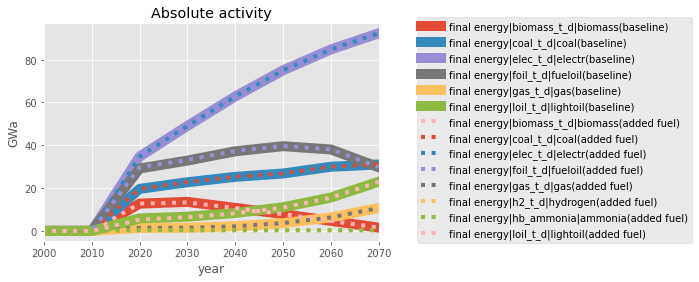

In [22]:
fig = plt.figure()
ax = plt.subplot(111)


for key, linestyle in zip(data2.keys(), [ 'solid','dotted', '--']):
    print(key)
    print(linestyle)
    if key=='baseline':
        linewidth=10
    else: 
        linewidth=4
    data2[key].plot(ax=ax, subplots=False, ylabel='GWa', linestyle=linestyle, linewidth=linewidth)

ax.set_title('Absolute activity')
ax.set_xlim([2000,2070])
ax.legend(bbox_to_anchor=(1.1, 1.05))



extended with h2 and nh3


added fuel
x label location is outside data range!


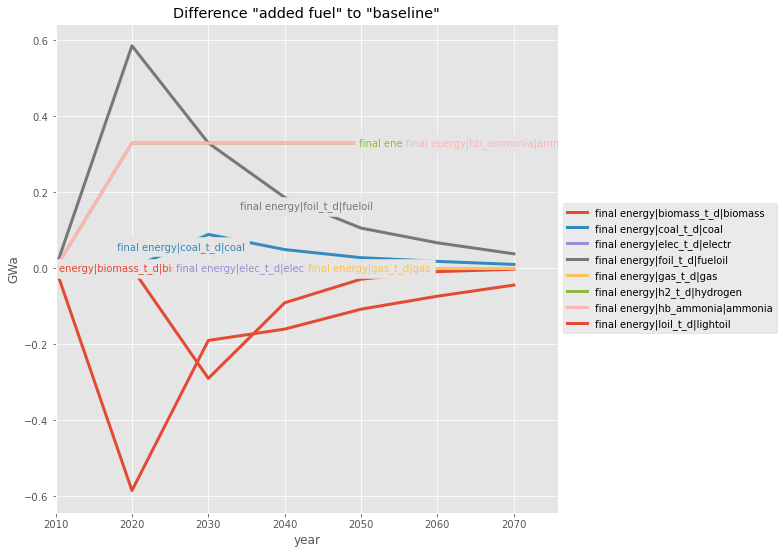

In [25]:
# plot differences
data2['difference'] = pd.DataFrame()
print(scenario_name)
for col in [x.split('(')[0] for x in data2[scenario_name].columns]:
    try:
        data2['difference'][col] = data2[scenario_name].fillna(0).loc[:, f'{col}({scenario_name})'] - data2['baseline'].fillna(0).loc[:, f'{col}(baseline)']
    except KeyError:
        data2['difference'][col] = data2[scenario_name].fillna(0).loc[:, f'{col}({scenario_name})'] 

fig = plt.figure(figsize=(9,9))
ax = plt.subplot(111)

data2['difference'].plot(ax=ax, subplots=False, ylabel='GWa', title=f'Difference "{scenario_name}" to "baseline"', linestyle='solid', linewidth=3)
ax.legend(loc='center left',bbox_to_anchor=(1, .50))
lines = plt.gca().get_lines()
l1=lines[-1]
ax.set_xlim(2010)
labelLine(l1,0.6,label=r'$Re=${}'.format(l1.get_label()),ha='left',va='bottom',align = False)
labelLines(lines[:-1],align=False)

C:\Users\jankle\AppData\Local\Temp\ipykernel_17352\2235088790.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data2[case] = d.loc[:, (d.columns.str.contains(r'(primary energy)'))&(d.sum(axis=0)>0)]
output: mixed units ['-', 'GWa'] discarded
C:\Users\jankle\AppData\Local\Temp\ipykernel_17352\2235088790.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data2[case] = d.loc[:, (d.columns.str.contains(r'(primary energy)'))&(d.sum(axis=0)>0)]


baseline
solid
extended with h2 and nh3
dotted
extended with h2 and nh3
x label location is outside data range!


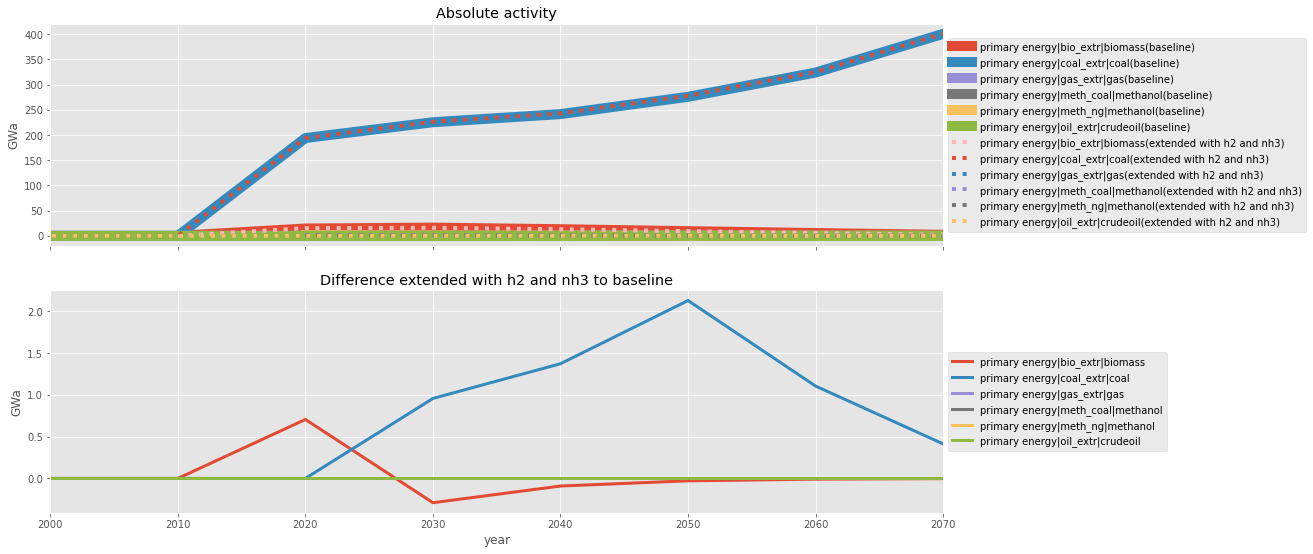

In [74]:
# primary energy use
data = {}
data2 = {}
scenario_name='extended with h2 and nh3'
for case in ['baseline', scenario_name]:
    s = message_ix.Scenario(mp, model='MESSAGEix South Africa', 
                               scenario=case)
    repp = Reporter.from_scenario(s)
    prepare_plots(repp)
    df_repp = quick_convert(repp)
    
    data[case] = pd.pivot_table(df_repp.data.reset_index(),
               index='year', columns='variable', values='value'
              )
    d =  data[case]
    data2[case] = d.loc[:, (d.columns.str.contains(r'(primary energy)'))&(d.sum(axis=0)>0)]

fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
for key, linestyle in zip(data2.keys(), [ 'solid','dotted', '--']):
    print(key)
    print(linestyle)
    if key=='baseline':
        linewidth=10
    else: 
        linewidth=4
    data2[key].plot(ax=axes[0], subplots=False, ylabel='GWa', linestyle=linestyle, linewidth=linewidth)

axes[0].set_title('Absolute activity')
axes[0].set_xlim([2000,2070])
axes[0].legend(loc='center left',bbox_to_anchor=(1, .50))

data2['difference'] = pd.DataFrame()
print(scenario_name)
for col in [x.split('(')[0] for x in data2[scenario_name].columns]:
    try:
        data2['difference'][col] = data2[scenario_name].fillna(0).loc[:, f'{col}({scenario_name})'] - data2['baseline'].fillna(0).loc[:, f'{col}(baseline)']
    except KeyError:
        data2['difference'][col] = data2[scenario_name].fillna(0).loc[:, f'{col}({scenario_name})'] 

data2['difference'].plot(ax=axes[1], subplots=False, ylabel='GWa', title=f'Difference {scenario_name} to baseline', linestyle='solid', linewidth=3)
axes[1].legend(loc='center left',bbox_to_anchor=(1, .50))
l1 = axes[1].get_lines()[-1]
labelLine(l1,0.6,label=r'$Re=${}'.format(l1.get_label()),ha='left',va='bottom',align = False)
labelLines(lines[:-1],align=False)
        

## Plot emissions

emission_factor: mixed units ['MtCO2eq/GWa', 'tCO2/kWa'] discarded
ixmp.reporting.computations - WARNING: emission_factor: mixed units ['MtCO2eq/GWa', 'tCO2/kWa'] discarded


baseline
solid
added fuel
dotted
added fuel
x label location is outside data range!


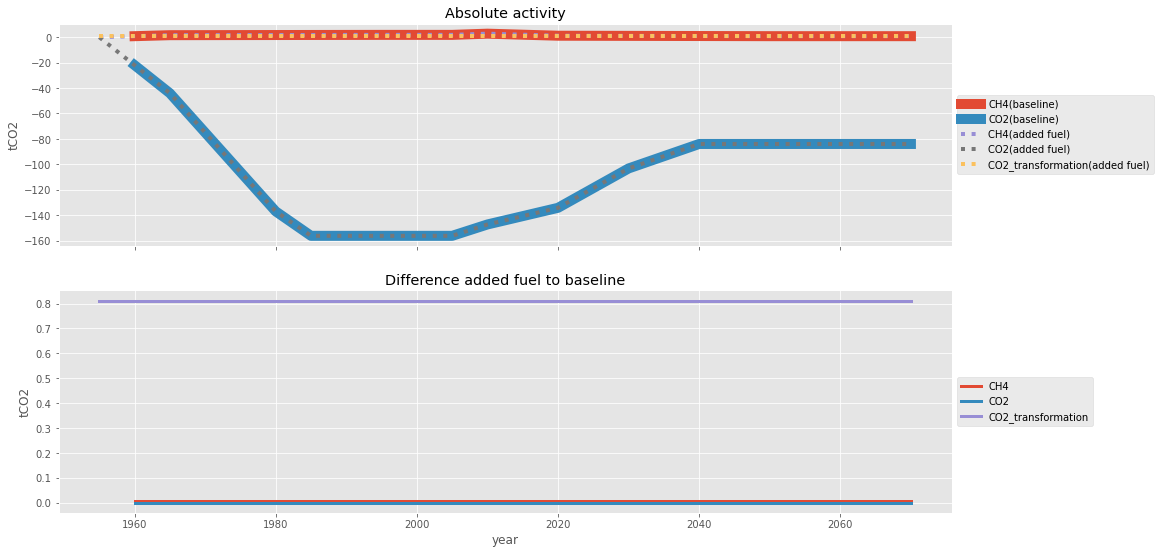

In [27]:
# primary energy use
data = {}
data2 = {}
key = 'emission_factor'
regexp = r''
ylabel='tCO2'
scenario_name='added fuel'
for case in ['baseline', scenario_name]:
    s = message_ix.Scenario(mp, model='MESSAGEix South Africa', 
                               scenario=case)
    repp = Reporter.from_scenario(s)
    df_repp = quick_convert(repp, key)
    
    data[case] = pd.pivot_table(df_repp.data.reset_index(),
               index='year', columns='variable', values='value'
              )
    data2[case] = data[case].loc[:, (data[case].columns.str.contains(regexp))&(data[case].sum(axis=0)!=0)]

fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
for key, linestyle in zip(data2.keys(), [ 'solid','dotted', '--']):
    print(key)
    print(linestyle)
    if key=='baseline':
        linewidth=10
    else: 
        linewidth=4
    data2[key].plot(ax=axes[0], subplots=False, ylabel=ylabel, linestyle=linestyle, linewidth=linewidth)

axes[0].set_title('Absolute activity')
axes[0].legend(loc='center left',bbox_to_anchor=(1, .50))

data2['difference'] = pd.DataFrame()
print(scenario_name)
for col in [x.split('(')[0] for x in data2[scenario_name].columns]:
    try:
        data2['difference'][col] = data2[scenario_name].fillna(0).loc[:, f'{col}({scenario_name})'] - data2['baseline'].fillna(0).loc[:, f'{col}(baseline)']
    except KeyError:
        data2['difference'][col] = data2[scenario_name].fillna(0).loc[:, f'{col}({scenario_name})'] 

data2['difference'].plot(ax=axes[1], subplots=False, ylabel=ylabel, title=f'Difference {scenario_name} to baseline', linestyle='solid', linewidth=3)
axes[1].legend(loc='center left',bbox_to_anchor=(1, .50))
l1 = axes[1].get_lines()[-1]
labelLine(l1,0.6,label=r'$Re=${}'.format(l1.get_label()),ha='left',va='bottom',align = False)
labelLines(lines[:-1],align=False)

# set xlim
#axes[0].set_xlim([2000,2070])

In [28]:
data[case].loc[:, (data[case].sum(axis=0)<0)]

variable,CO2(added fuel)
year,
1955,0.000000
1960,-22.037069
1965,-44.074139
1970,-75.061125
1975,-106.048111
1980,-137.035097
1985,-156.268050
1990,-156.268050
1995,-156.268050


In [14]:
# close platform connection
mp.close_db()